In [1]:
import os
import re
import string
from functools import partial

import nltk
import polars as pl
import tensorflow as tf
from nltk.corpus import stopwords

nltk.download('stopwords')

2023-08-06 23:29:43.549128: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 23:29:43.581176: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 23:29:43.581812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 23:29:44.313691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
device = tf.config.list_physical_devices()
device

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
file = 'dev.gzip'
dev_df = pl.read_parquet(file)
dev_df.head()

Log,Target
str,str
""" 1119803499 20…","""normal"""
""" 1119803105 20…","""normal"""
""" 1121496169 20…","""normal"""
""" 1120968564 20…","""normal"""
""" 1120953205 20…","""normal"""


In [4]:
from utils.utils import get_dataset, get_tokenizer

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dev_dataset = get_dataset(file_path= file, batch_size=1,shuffle= False)

In [6]:
for word in dev_dataset.take(2):
    print(word)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'rmnccju rmnccju ras kernel info data store interrupt caused dcbf'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'rmnecju rmnecju ras kernel info program interrupt illegal instruction'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)


In [7]:
token_vec, voc = get_tokenizer(dev_dataset, sequence_length= 15)

In [8]:
out = token_vec(['rmnccju rmnccju ras kernel info data store interrupt caused dcbf'])
out

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 26,  26,   3,   4,   5,  35,  75,  25,  95, 242,   0,   0,   0,
          0,   0]])>

In [9]:
log_ds = dev_dataset.map(lambda text,label: text)
sequence_length = 10
tokenizer_layer = tf.keras.layers.TextVectorization(split= 'whitespace', output_mode= 'int',
                                              output_sequence_length= sequence_length)
tokenizer_layer.adapt(log_ds)
vocab_size = tokenizer_layer.vocabulary_size()

In [10]:
vocab = 1000
vocab_size

420

In [13]:
LR = 0.001
OPTIM = tf.keras.optimizers.Adam(learning_rate=LR)
LOSS = "binary_crossentropy"
filter = 10
kernel = 5
stride = 1
pad= "same"
embed_dim = 100

def build_model():
    """ 1DCNN doc

    Parameters
    ----------
    file_path : str

    Returns
    -------
    model : object
        model
    """
    input_layer = tf.keras.layers.Input(shape= (100))
    embeding_layer = tf.keras.layers.Embedding(input_dim= vocab_size + 1,output_dim= embed_dim,
                                               mask_zero= True)
    DefaultConv1D = partial(tf.keras.layers.Conv1D, kernel_size= 3, strides= 1 , padding= pad, 
                           activation= 'relu')
    DefualtMaxpool1D = partial(tf.keras.layers.MaxPool1D, pool_size= 2)
    model = tf.keras.Sequential([input_layer, embeding_layer,
                         DefaultConv1D(30),
                         DefualtMaxpool1D(),
                         tf.keras.layers.GlobalMaxPool1D(),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(units= 20, activation= 'relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(units= 1, activation= 'sigmoid')
                         ])
    model.compile(loss= LOSS, optimizer= OPTIM, metrics= ['f1_score'])
    return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          42100     
                                                                 
 conv1d (Conv1D)             (None, 100, 30)           9030      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 30)            0         
 D)                                                              
                                                                 
 global_max_pooling1d (Glob  (None, 30)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 20)                6

In [16]:
os.chdir('../')
%pwd

'/workspace/log_anomaly'

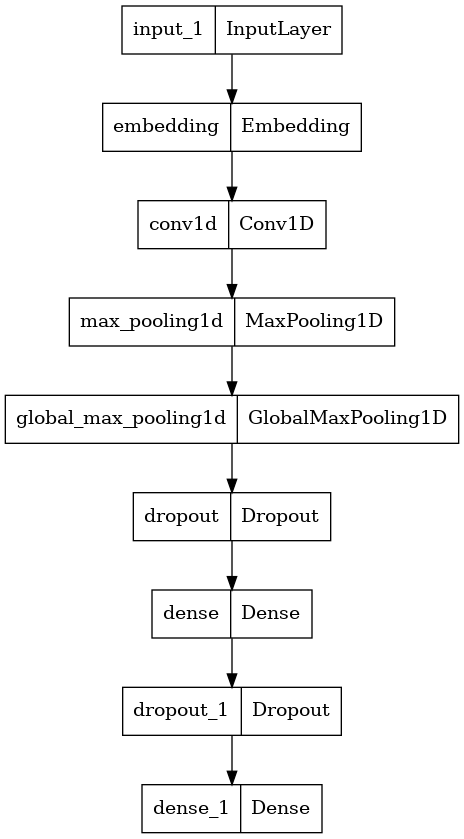

In [17]:
tf.keras.utils.plot_model(model,
                          to_file= 'doc/model.png')